[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MeteoSwiss/opendata-nwp-demos/blob/main/07_where_will_it_rain_next_24h.ipynb)

# 🌧️ Where Will It Rain in the next 24h?

Planning a hike or outdoor event? Knowing **where it might rain in the next 24h** can make all the difference — and a **[probabilistic forecast](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/probability-in-forecasts.html)** gives more insight than a simple yes-no answer.

This notebook uses the **ICON-CH1-EPS** ensemble system to map the probability that total precipitation will exceed **0.1 mm/day** over the next 24 hours across Switzerland and surrounding regions.


### 🔍 What This Notebook Covers:
- 📥 Fetch perturbed ICON-CH1-EPS forecast data using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `ogd_api` module
- 🗺️ Visualize precipitation probabilities with [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html)

Let’s explore the forecast and answer the question:  **Where will it rain in the next 24h?**

## 📦 Install Dependencies (Colab only)
This cell installs all required dependencies if you're running the notebook in Google Colab. It is automatically skipped when running in a local Jupyter environment.

In [1]:
# 📦 Google Colab Setup (skipped if not running in Colab)
import sys

def is_colab():
    return "google.colab" in sys.modules

if is_colab():
    !git clone https://github.com/MeteoSwiss/opendata-nwp-demos.git
    %cd opendata-nwp-demos
    !pip install poetry && poetry config virtualenvs.in-project true && poetry install --no-ansi
    import sys, os, pathlib
    venv = pathlib.Path(".venv")
    site = venv / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
    sys.path.insert(0, str(site))
    os.environ["ECCODES_DEFINITION_PATH"] = str((venv / "share/eccodes-cosmo-resources/definitions").resolve())

## 📥 Retrieve ICON-CH1-EPS Data

In [2]:
from meteodatalab import ogd_api
from datetime import timedelta


# Create request
req = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="TOT_PREC",
    ref_time="latest",
    perturbed=True,           # ensemble mode
    lead_time=timedelta(hours=24)
)

# Fetch data
da = ogd_api.get_from_ogd(req)

### Regridding to Regular Grid (EPSG:4326)

Model output is remapped to a regular lat/lon grid using `iconremap()` from `meteodatalab.regrid` for visualization.

In [3]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Define ~1 km target grid over ICON-CH1-EPS domain
extent = (-0.817, 18.183, 41.183, 51.183)  # (xmin, xmax, ymin, ymax)
nx, ny = 429, 295

# Create regular lat/lon grid (EPSG:4326) and regrid
destination = regrid.RegularGrid(CRS.from_epsg(4326), nx, ny, *extent)
da_geo = regrid.iconremap(da, destination)


## 🎯 Compute Probability > 0.1 mm

In [4]:
import numpy as np

# Boolean mask where member values > 0.1 mm
mask = (da_geo > 0.1)
prob_prec = mask.mean(dim="eps") * 100
prob_prec.attrs = da.attrs
prob_prec.attrs["long_name"] = "Probability of precipitation > 0.1 mm"
prob_prec.attrs["units"] = "%"

## 🗺️ Plot Probability Map

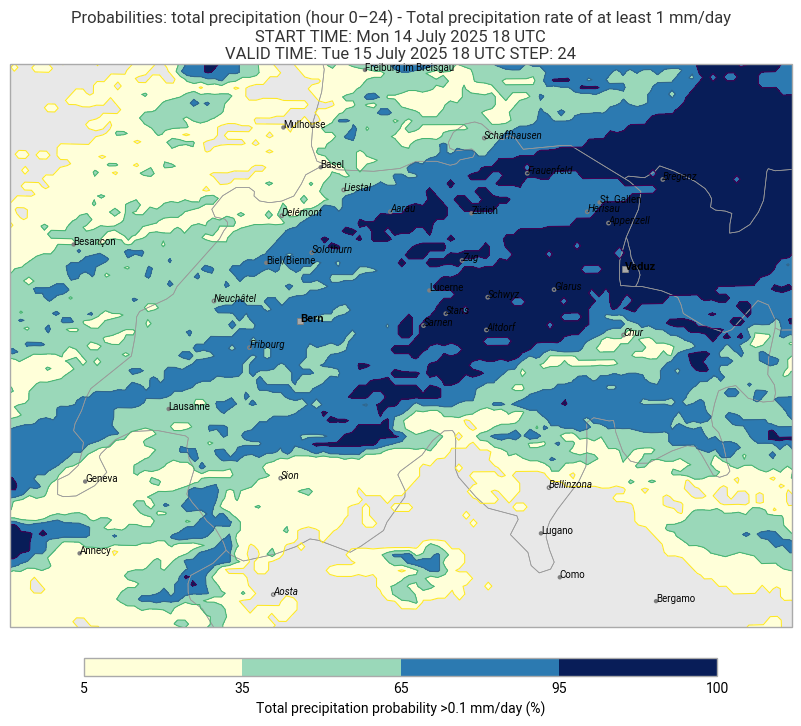

In [5]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from earthkit.plots.geo import bounds, domains
from earthkit.plots.styles import Style, Contour
import earthkit


# === Setup Domain (Switzerland) ===
bbox = bounds.BoundingBox(5.7, 10.5, 45.6, 48, ccrs.Geodetic())
domain = domains.Domain.from_bbox(bbox=bbox)

# === Define Style ===
levels = [5, 35, 65, 95, 100.01]  # Probability thresholds

contourf_style = Style(
    levels=levels,
    colors="YlGnBu",
    legend_style="colorbar",
)


contour_style = Contour(
    levels=levels,
    legend_style=None
)

# === Create Map ===
chart = earthkit.plots.Map(domain=domain)

# Plot filled contours and line contours
chart.contourf(prob_prec, x="lon", y="lat", style=contourf_style)
chart.contour(prob_prec, x="lon", y="lat", style=contour_style)

# Add map features
chart.borders()
chart.cities("high")
chart.land()
chart.legend(label="Total precipitation probability >0.1 mm/day (%)")

# === Title Setup ===
# Extract reference and lead time
ref_time = pd.to_datetime(prob_prec.coords["ref_time"].values[0])
lead_time = prob_prec.coords["lead_time"].values[0]
lead_hours = int(lead_time.astype("timedelta64[h]") / np.timedelta64(1, "h"))
valid_time = ref_time + pd.to_timedelta(lead_hours, unit="h")

# Format and apply title
title_text = "\n".join([
    "Probabilities: total precipitation (hour 0–24) - Total precipitation rate of at least 1 mm/day",
    f"START TIME: {ref_time.strftime('%a %d %B %Y %H')} UTC",
    f"VALID TIME: {valid_time.strftime('%a %d %B %Y %H')} UTC STEP: {lead_hours}"
])
chart.title(text=title_text)

# === Show Plot ===
chart.show()
